In [ ]:
import torch            # for DL & ML tasks like tensor computation
from torch import nn    # tool for building and training NN

import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms   # for image preprocessing

Tensor: DS to rep data & perform computations. Multidimensional array.

In [3]:
torch.manual_seed(111)    # any random operations performed by PyTorch, such as initializing weights in neural networks or shuffling data during training,
                          # will produce the same results each time the code is run with the same seed. any random processes within your code,
                          # such as initializing model weights, shuffling datasets, or generating random numbers for simulations, will produce the same outcomes each time the code is run with the same seed.

In [4]:
device = ""
if torch.cuda.is_available():       # produced by NVIDIA, API or Paralled Computing Platform
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# ToTensor()  =>  from image's any format to tensor
# Normalise(mean,sd) =>  tensor-mean/sd => [-1,1]
# compose()   => combines both process like a single pipeline

In [ ]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

100%|██████████| 9912422/9912422 [00:00<00:00, 110699709.36it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 73105427.78it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28613061.42it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5147400.37it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

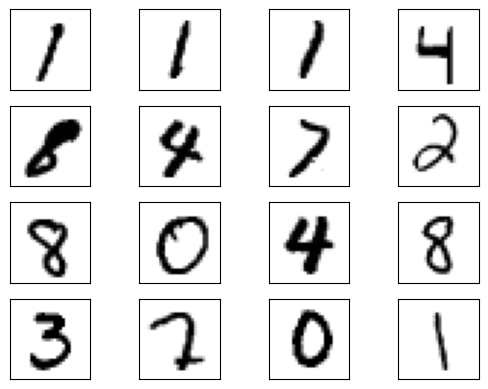

In [ ]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [ ]:
class Discriminator(nn.Module):         # nn.module is the base class for all NN models in pytorch
    def __init__(self):
        super().__init__()              # call constructor of parent class to initialise discriminator class
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output
    
discriminator = Discriminator().to(device=device)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

In [ ]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.25374892354011536
Epoch: 0 Loss G.: 1.6618931293487549
Epoch: 1 Loss D.: 0.4499734044075012
Epoch: 1 Loss G.: 1.6750097274780273
Epoch: 2 Loss D.: 0.3079472482204437
Epoch: 2 Loss G.: 1.6997854709625244
Epoch: 3 Loss D.: 0.3399932086467743
Epoch: 3 Loss G.: 1.6629254817962646
Epoch: 4 Loss D.: 0.3982921242713928
Epoch: 4 Loss G.: 1.433502435684204
Epoch: 5 Loss D.: 0.40935617685317993
Epoch: 5 Loss G.: 1.506752848625183
Epoch: 6 Loss D.: 0.4277917444705963
Epoch: 6 Loss G.: 1.4607088565826416
Epoch: 7 Loss D.: 0.5314109921455383
Epoch: 7 Loss G.: 1.3975515365600586
Epoch: 8 Loss D.: 0.43242859840393066
Epoch: 8 Loss G.: 1.481703281402588
Epoch: 9 Loss D.: 0.6285288333892822
Epoch: 9 Loss G.: 1.324055790901184
Epoch: 10 Loss D.: 0.543901801109314
Epoch: 10 Loss G.: 1.4650194644927979
Epoch: 11 Loss D.: 0.40467339754104614
Epoch: 11 Loss G.: 1.3112834692001343
Epoch: 12 Loss D.: 0.6400980949401855
Epoch: 12 Loss G.: 0.8554190993309021
Epoch: 13 Loss D.: 0.656013131141

In [ ]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

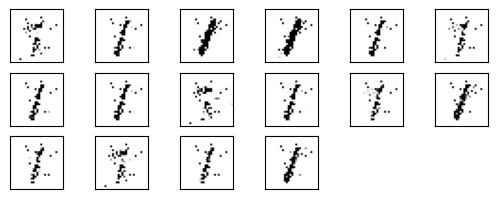

In [ ]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])